# Sampling distribution of the mean details


I find this is a very sneaky detail, and I have not seen anyone explain it in any other textbook.

- CASE 1 `norm(mu, sehat)`: the sampling distribution centred around the known population mean (as we can obtain from simulation when the population parameters are known).
  a hypothetical distribution centered on true population mean.
  This plot describes some hypothetical half-knowledge scenario,
  where the experimenter knows population mean mu,
  but doesn't know the variance,
  so we use CLT or BOOT for the estimated dispersion,
  but show dist. centered at muK (the population mean).

- CASE 2 `norm(xbar, sehat)`: the sampling distribution centred at the sample mean (which corresponds to the realistic, best effort scenario when we don't know either the population mean or the population var)
  A realistic experimenter who only knows `sample`
  will make their "best guess" of the population mean as `xbar = mean(sample)`.
  We can plot the sampling distribution centered at xbar.


#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Plot helper functions
from ministats import plot_pdf

In [3]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
RCPARAMS.update({'figure.figsize': (10, 3)})   # good for screen
# RCPARAMS.update({'figure.figsize': (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# Useful colors
snspal = sns.color_palette()
blue, orange, purple = snspal[0], snspal[1], snspal[4]

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/stats/estimators"

<Figure size 640x480 with 0 Axes>

In [4]:
# set random seed for repeatability
np.random.seed(42)

## Estimators

In [5]:
def mean(sample):
    return sum(sample) / len(sample)

def var(sample):
    xbar = mean(sample)
    sumsqdevs = sum([(xi-xbar)**2 for xi in sample])
    return sumsqdevs / (len(sample)-1)

def std(sample):
    s2 = var(sample)
    return np.sqrt(s2)


## Particular sample: kombucha Batch 02


In [6]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
# kombucha

In [7]:
batch02 = kombucha[kombucha["batch"]==2]
ksample02 = batch02["volume"]
n = ksample02.count()
n

20

In [8]:
ksample02.values

array([ 995.83,  999.44,  978.64, 1016.4 ,  982.07,  991.58, 1005.03,
        987.55,  989.42,  990.91, 1005.51, 1022.92, 1000.42,  988.82,
       1005.39,  994.04,  999.81, 1011.75,  992.52, 1000.09])

In [9]:
mean(ksample02)

997.9069999999999

^ underestimate of true population mean $\mu_K = 1000$ ...

In [10]:
std(ksample02)

11.149780314097285

^ overestimate of true population std $\sigma_K = 10$...

## Population

We assume the kombucha volume (when the production is regular/stable) can be modelled as the random variable $K \sim \mathcal{N}(\mu_K=1000, \sigma_K=10)$.


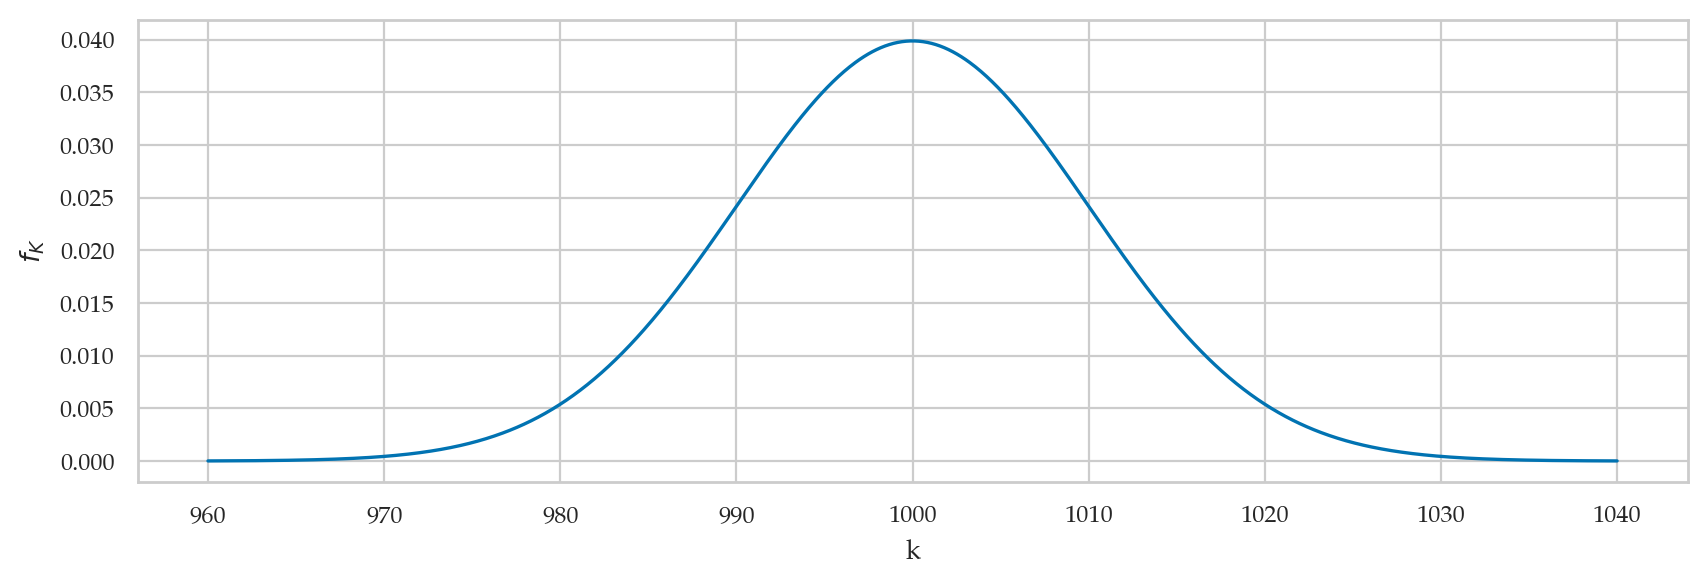

In [11]:
from scipy.stats import norm
muK = 1000
sigmaK = 10
rvK = norm(muK, sigmaK)

ax = plot_pdf(rvK, xlims=[960,1040], rv_name="K")

## True sampling distribution of the mean

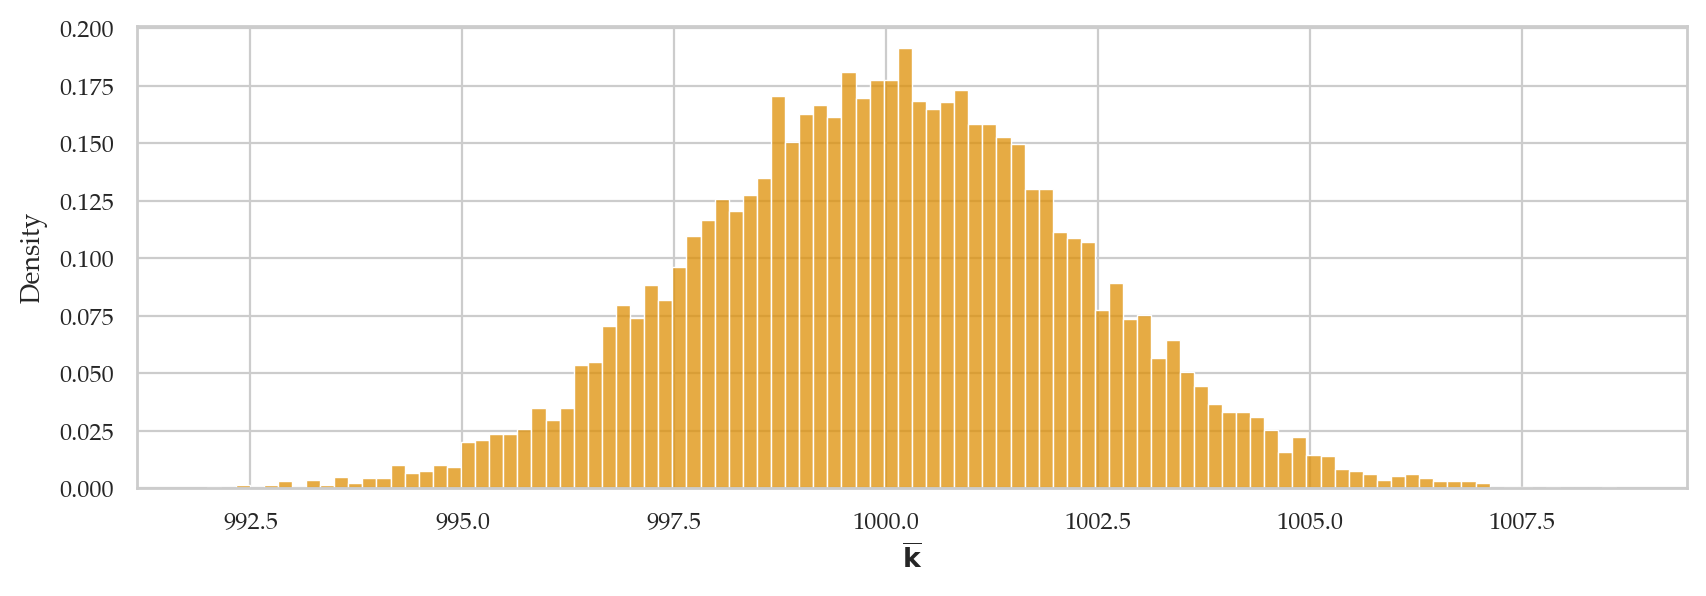

In [12]:
from stats_helpers import gen_sampling_dist

np.random.seed(42)
kbars40 = gen_sampling_dist(rvK, estfunc=mean, n=n, N=10000)
ax = sns.histplot(kbars40, stat="density", bins=100, color=orange, label="simulation")
ax.set_xlabel("$\overline{\mathbf{k}}$");

What we see above is the "ground truth" about the sampling distribution of the mean
obtained through simulation.

All subsequent cases will try to approximate this properties of this distribution in one way or another.

## CASE 0: Know population mean and variance


If we know $\mu_K$ and $\sigma_K$ we can use the central limit theorem

In [13]:
muK

1000

In [14]:
seCLT = sigmaK / np.sqrt(n)
seCLT

2.23606797749979

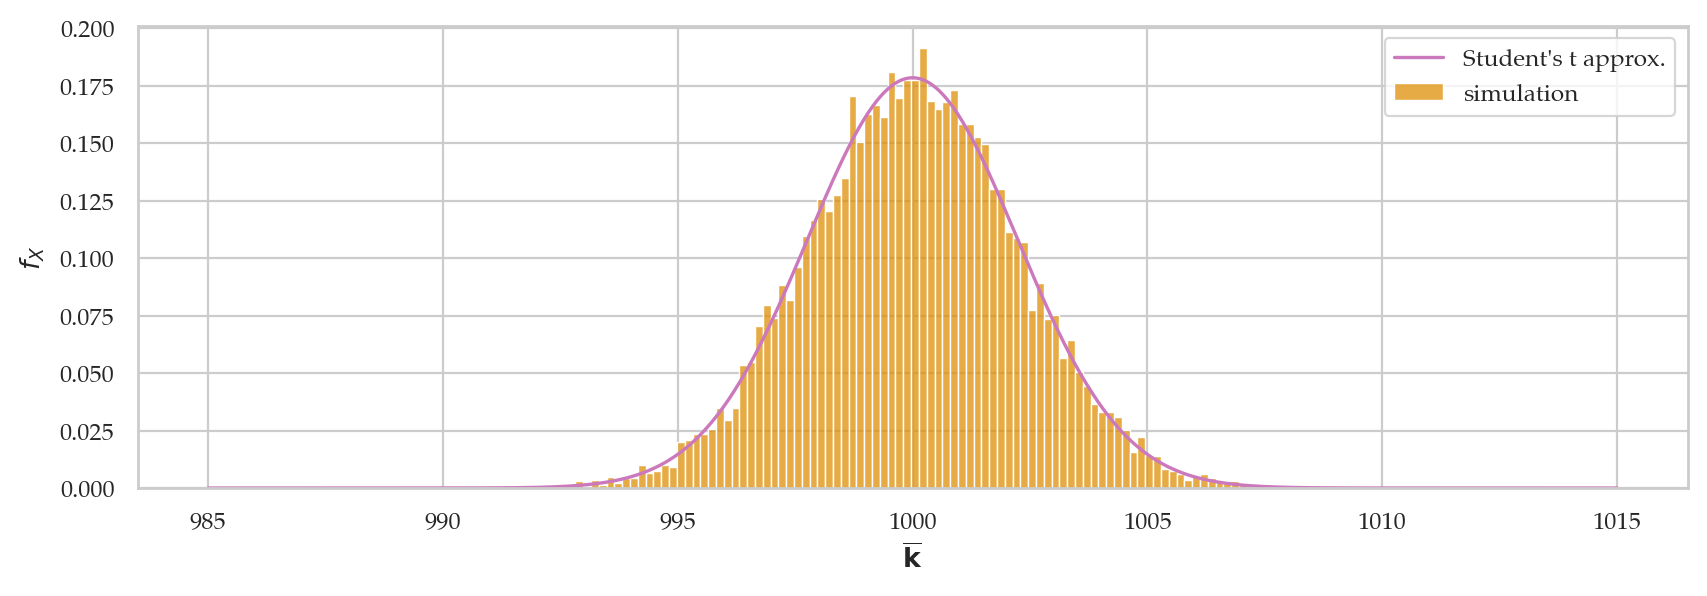

In [15]:
from scipy.stats import norm
rvKbarCLT = norm(loc=muK, scale=seCLT)

ax = sns.histplot(kbars40, stat="density", bins=100, color=orange, label="simulation")
plot_pdf(rvKbarCLT, ax=ax, xlims=[985,1015], color=purple, label="Student's t approx.")
ax.set_xlabel("$\overline{\mathbf{k}}$");

#### Can I haz 90% confidence interval plz

In [16]:
from scipy.stats import norm

# for 90% confidence interval we'll need
alpha = 0.1
quantiles = np.array([alpha/2, 1-alpha/2])
norm.ppf(quantiles, loc=muK, scale=sigmaK/np.sqrt(n))

array([ 996.32199548, 1003.67800452])

The above interval tells us the range of sample means we can expect 
to observe 90% of the time.

In [17]:
# true 90% CI for sample mean
[np.percentile(kbars40, 5),
 np.percentile(kbars40, 95)]

[996.3769782356497, 1003.7065570446886]

So far so good, the CLT is working.
We can say "good job mate" to de Moivre, Laplace, and Lyapunov and move on to the next case.

## Case 1: Population mean is known, but variance is unknown

In [18]:
# estimate for the standard deviation
std(ksample02)

11.149780314097285

In [19]:
# estimate for the standard error of the mean
sehat = std(ksample02) / np.sqrt(n)
sehat

2.4931666716510485

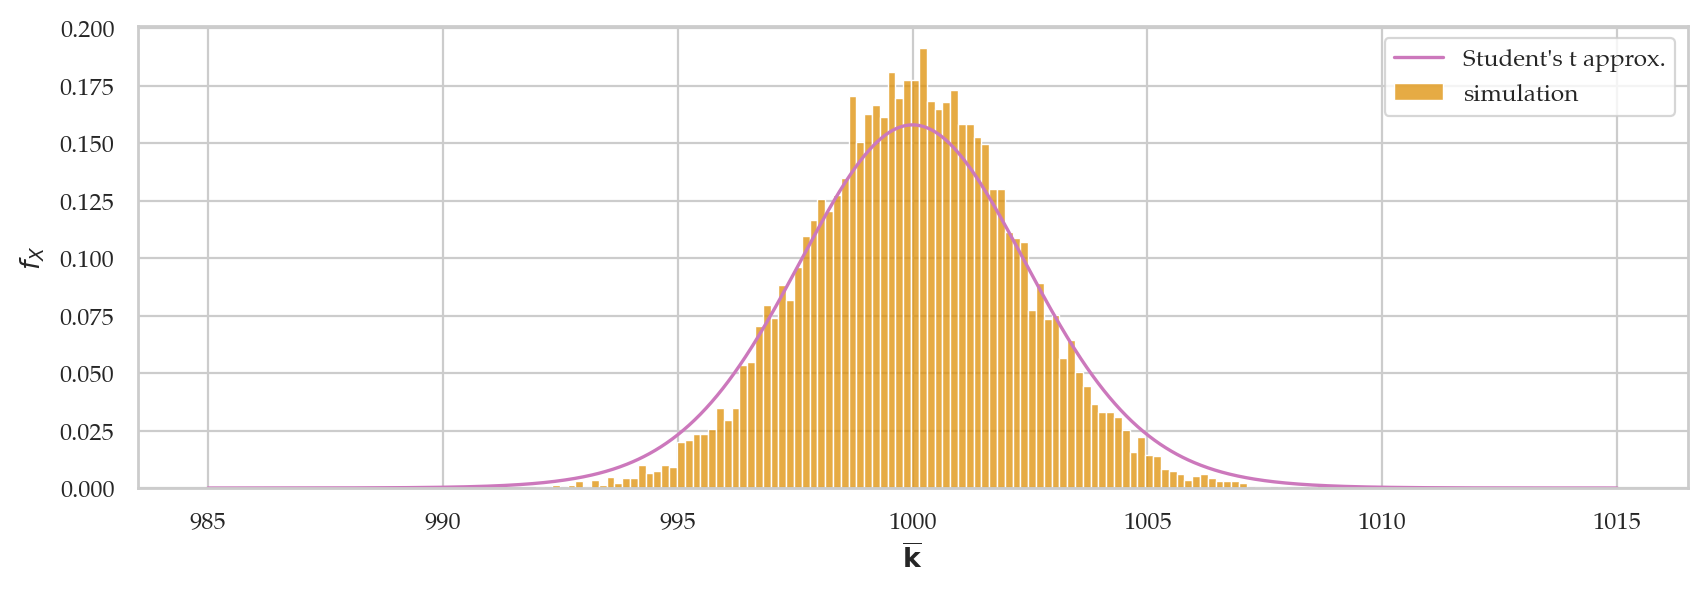

In [20]:
from scipy.stats import t
rvKbar1 = t(df=n-1, loc=muK, scale=sehat)

ax = sns.histplot(kbars40, stat="density", bins=100, color=orange, label="simulation")
plot_pdf(rvKbar1, ax=ax, xlims=[985,1015], color=purple, label="Student's t approx.")
ax.set_xlabel("$\overline{\mathbf{k}}$");

#### 90% confidence interval of sample means we can expect to observe

In [21]:
from scipy.stats import t

# for 90% confidence interval we'll need
alpha = 0.1
quantiles = np.array([alpha/2, 1-alpha/2])
t.ppf(quantiles, df=n-1, loc=muK, scale=sehat)

array([ 995.6889837, 1004.3110163])

The above interval tells us the range of sample means we can expect 
to observe 90% of the time.

In [22]:
# true 90% CI for sample mean
[np.percentile(kbars40, 5),
 np.percentile(kbars40, 95)]

[996.3769782356497, 1003.7065570446886]

So far so good, Student's $t$-distribution seems
to be a bit conservative (giving a wider confidence interval than necessary),
but hey if you're getting the coverage you promised,
then we can say "good job mate" to Gosset.

## Case 2: Both population mean and variance are unknown

### Tool 1: Analytical approximations based on sample `ksample02`

If we we plug in $\overline{\mathbf{x}}$ for $\mu$
and $s_{\mathbf{x}}$ for $\sigma$,
in Gosset's 
what do we get?

In [23]:
obsmean02 = mean(ksample02)
obsmean02

997.9069999999999

In [24]:
obsvar02 = var(ksample02)
obsvar02

124.31760105263136

In [25]:
# standard error estimated from `ksample02`
n = ksample02.count()
seKhat02 = np.sqrt( obsvar02 / n )
seKhat02

2.4931666716510485

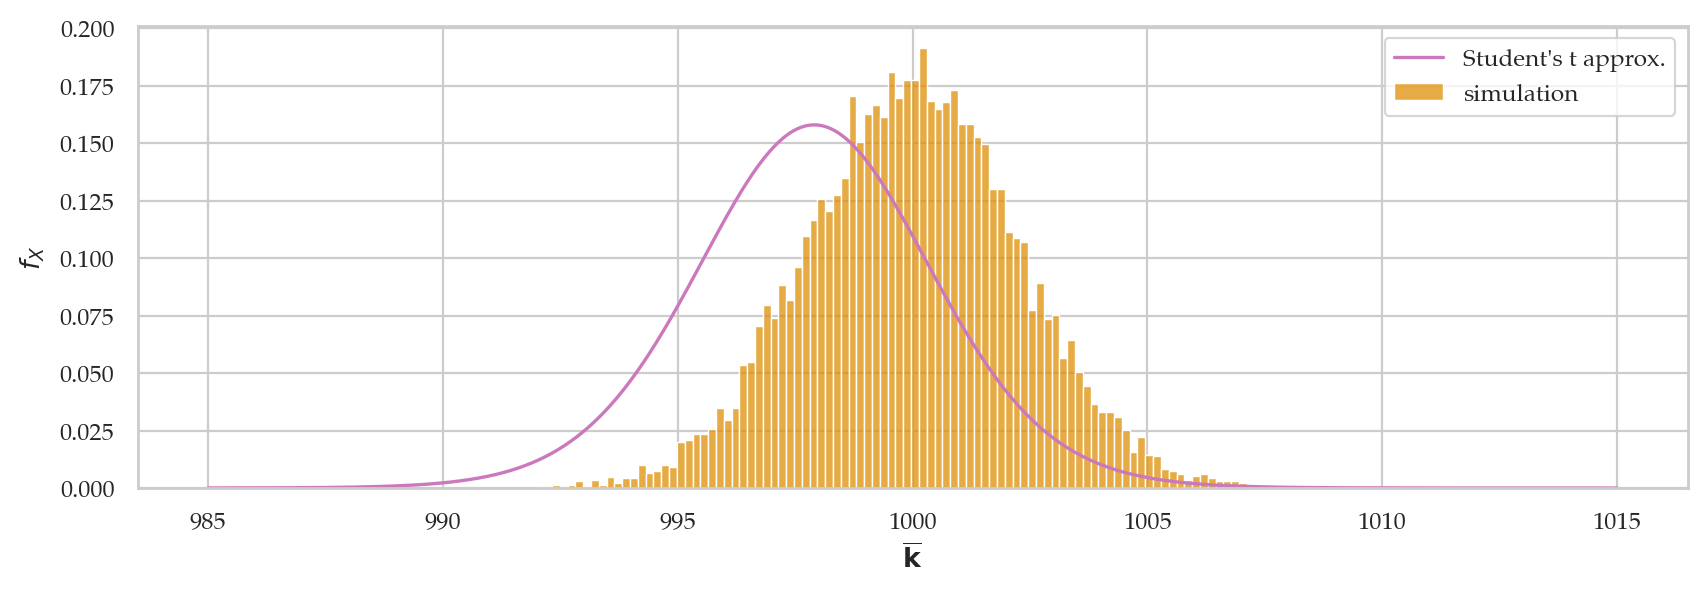

In [26]:
from scipy.stats import t

df = n - 1  # degrees of freedom
rvKbarA = t(df, loc=obsmean02, scale=seKhat02)

ax = sns.histplot(kbars40, stat="density", bins=100, color=orange, label="simulation")
plot_pdf(rvKbarA, ax=ax, xlims=[985,1015], color=purple, label="Student's t approx.")
ax.set_xlabel("$\overline{\mathbf{k}}$");

#### 90% confidence interval for the population mean

In [27]:
from scipy.stats import t

alpha = 0.1
quantiles = np.array([alpha/2, 1-alpha/2])
t.ppf(quantiles, df=n-1, loc=obsmean02, scale=sehat)

array([ 993.5959837, 1002.2180163])

### Tool 2: Bootstrap estimate based on sample `ksample02`

In [28]:
from stats_helpers import gen_boot_dist

<AxesSubplot: ylabel='Density'>

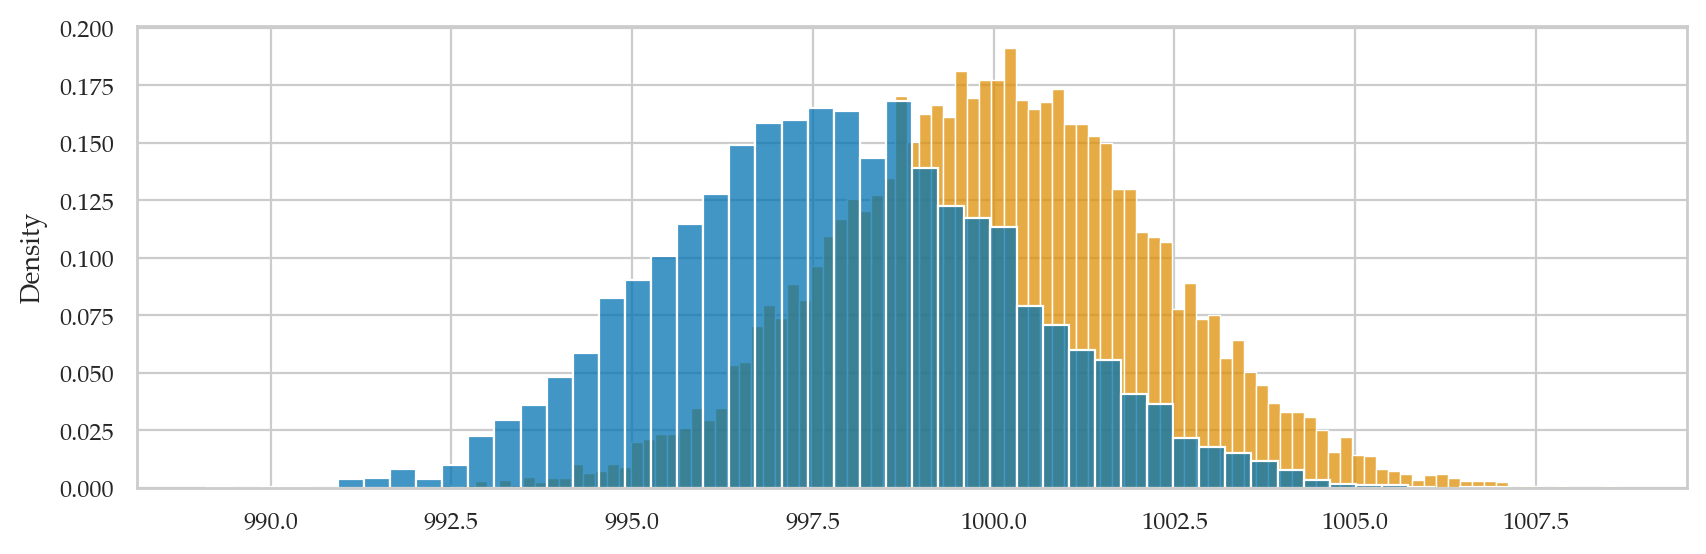

In [29]:
# true sampling distribution
ax = sns.histplot(kbars40, stat="density", bins=100, color=orange, label="simulation")

# boostrap estimated sampling dist from sample `ksample02`
kbars02_boot = gen_boot_dist(ksample02, estfunc=mean)
sns.histplot(kbars02_boot, bins=50, stat="density", ax=ax)

#### 90% confidence interval for the population mean

In [30]:
[np.percentile(kbars02_boot, 5),
 np.percentile(kbars02_boot, 95)]

[993.985925, 1001.9336249999998]

## Combined picture for CASE 2

A realistic experimenter who only knows ksample will make their "best guess" of the population mean as kbar = mean(ksample), then draw the sampling distribution centered at kbar, as in this figure:

I think nobody wants to shows this kind of figure because it looks really bad. Look how far off the CLT and bootstrap approximations are relative to the true population mean mu=1000.

sample mean = 997.9069999999999
 sample var = 124.31760105263136
 sample std = 11.149780314097285


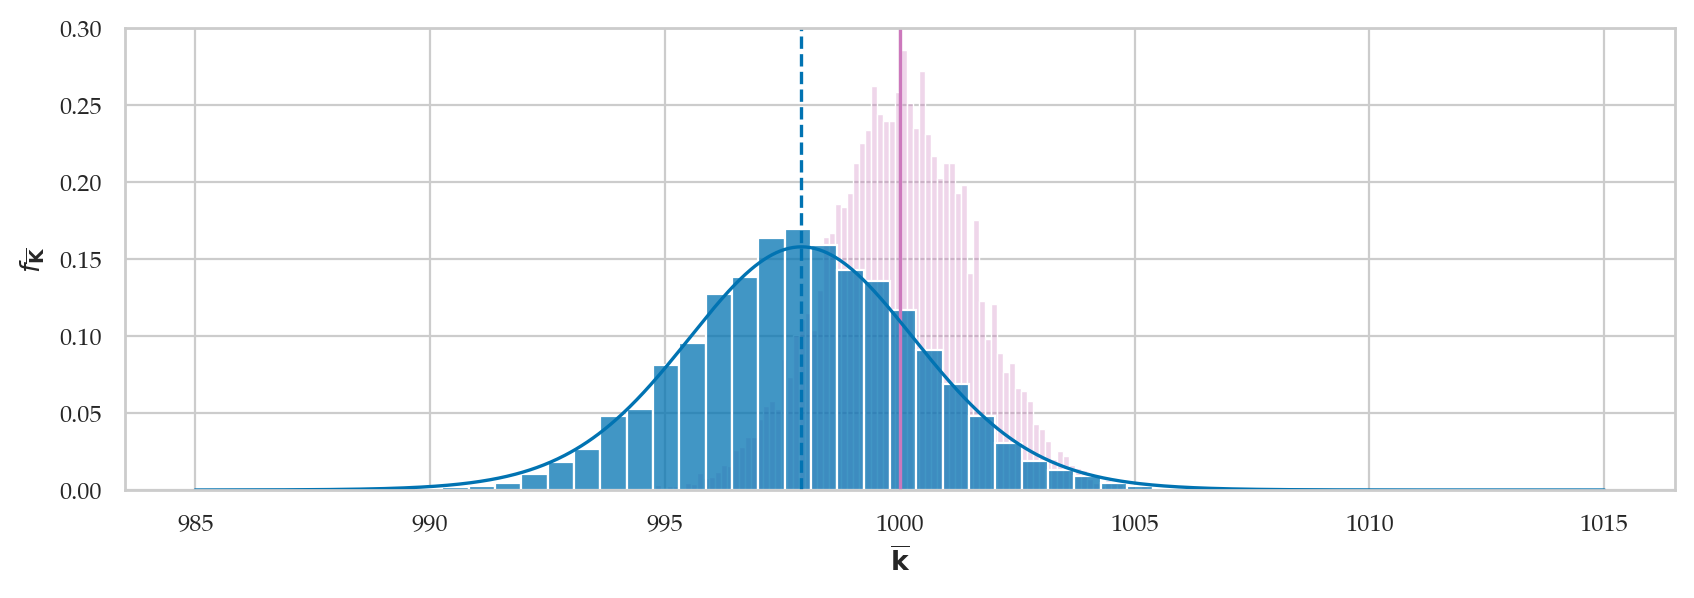

In [31]:
fig, ax = plt.subplots()

# true sampling distribution
kbars40 = gen_sampling_dist(rvK, estfunc=mean, n=40)
sns.histplot(kbars40, stat="density", ax=ax, bins=100,
                  label="simulation", alpha=0.3, color="m")

# populatin mean
ax.axvline(rvK.mean(), linestyle="-", color='m')

# particular sample
n = ksample02.count()

obsmean02 = mean(ksample02)  # sample mean
ax.axvline(obsmean02, linestyle="--", color='b')

obsvar02 = var(ksample02)
print("sample mean =", obsmean02)
print(" sample var =", obsvar02)
print(" sample std =", np.sqrt(obsvar02))

# analytical approximation based on `ksample02` mean and var
from scipy.stats import t
df = n - 1  # degrees of freedom
seKhat02 = np.sqrt( obsvar02 / n )
rvKbarA = t(df, loc=obsmean02, scale=seKhat02)
plot_pdf(rvKbarA, ax=ax, xlims=[985,1015], color=blue, label="Student's t approx.")

# boostrap approx
kbars02_boot = gen_boot_dist(ksample02, estfunc=mean)
sns.histplot(kbars02_boot, bins=30, stat="density", ax=ax, label="boostrap approx.")

# add x-axis label and rm legend
ax.set_xlabel("$\overline{\mathbf{k}}$")
ax.set_ylabel("$f_{\overline{\mathbf{K}}}$")
ax.get_legend().remove()